In [1]:
library('igraph')
library('Matrix')
library('pracma')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




## 3(a)

+ 0/3990 edges from 87c4462:

+ 286/3990 edges from 87c4462:
  [1]   2->1   3->1   4->1   5->1   6->1   7->1   8->1   9->1  10->1  11->1
 [11]  12->1  13->1  14->1  16->1  18->1  19->1  20->1  21->1  22->1  23->1
 [21]  27->1  29->1  33->1  35->1  36->1  38->1  41->1  42->1  43->1  44->1
 [31]  45->1  50->1  51->1  52->1  53->1  57->1  60->1  62->1  63->1  67->1
 [41]  68->1  69->1  70->1  71->1  73->1  74->1  76->1  79->1  80->1  82->1
 [51]  84->1  87->1  88->1  89->1  90->1  93->1  94->1  95->1  96->1  98->1
 [61] 100->1 101->1 102->1 106->1 108->1 109->1 112->1 114->1 117->1 121->1
 [71] 122->1 126->1 127->1 128->1 131->1 134->1 135->1 137->1 140->1 141->1
 [81] 143->1 144->1 155->1 158->1 159->1 161->1 168->1 169->1 172->1 173->1
 [91] 175->1 177->1 183->1 185->1 188->1 199->1 203->1 204->1 206->1 209->1
+ ... omitted several edges

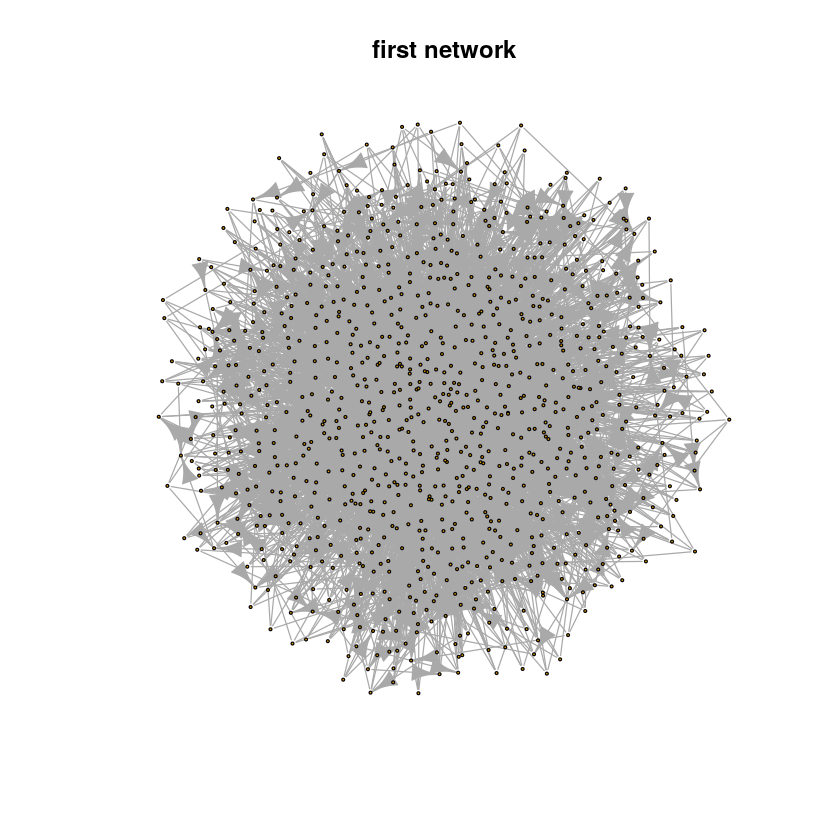

In [2]:
# create first network
g1 = sample_pa(1000, m=4, directed=TRUE)
plot(g1, vertex.size=1, vertex.label=NA, main='first network')

# number, mode='in' of edges related to the first node
E(g1)[from(1)]
E(g1)[to(1)]

+ 0/3990 edges from 7e6cf48:

+ 4/3990 edges from b3b277f:
[1] 1->254 1->680 1->694 1->841

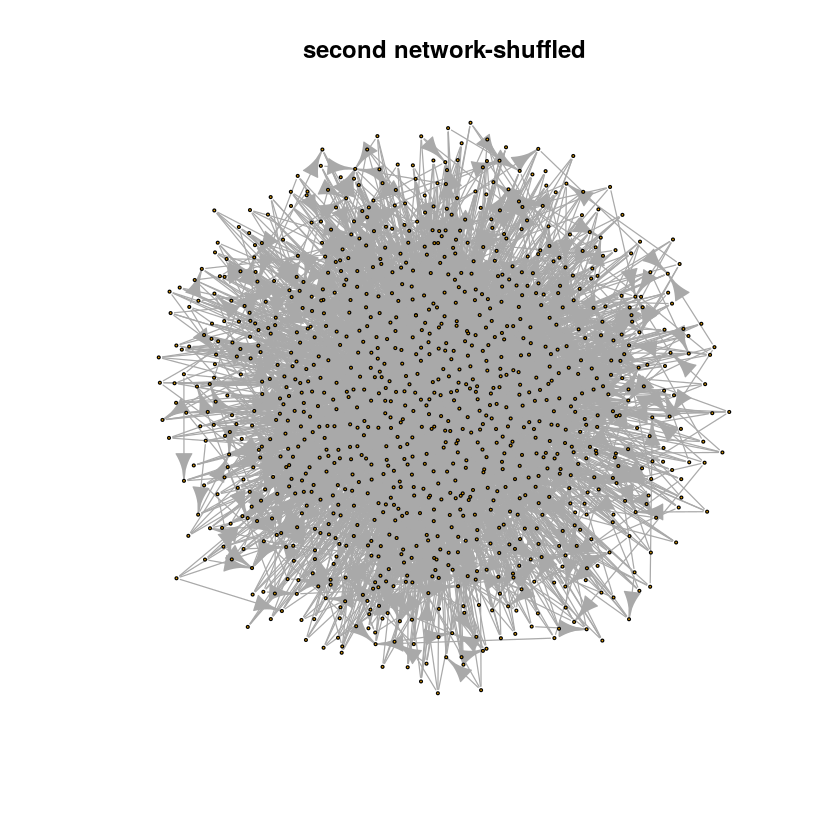

In [3]:
# create second network and shuffle
g2 = sample_pa(1000, m=4, directed=TRUE)
g2_shuffled = permute(g2, sample(1000))
plot(g2_shuffled, vertex.size=1, vertex.label=NA, main='second network-shuffled')

# number of edges related to the first node before and after shuffle
E(g2)[from(1)]
E(g2_shuffled)[from(1)]

+ 4/7980 edges from 3e9b01f:
[1] 1->254 1->680 1->694 1->841

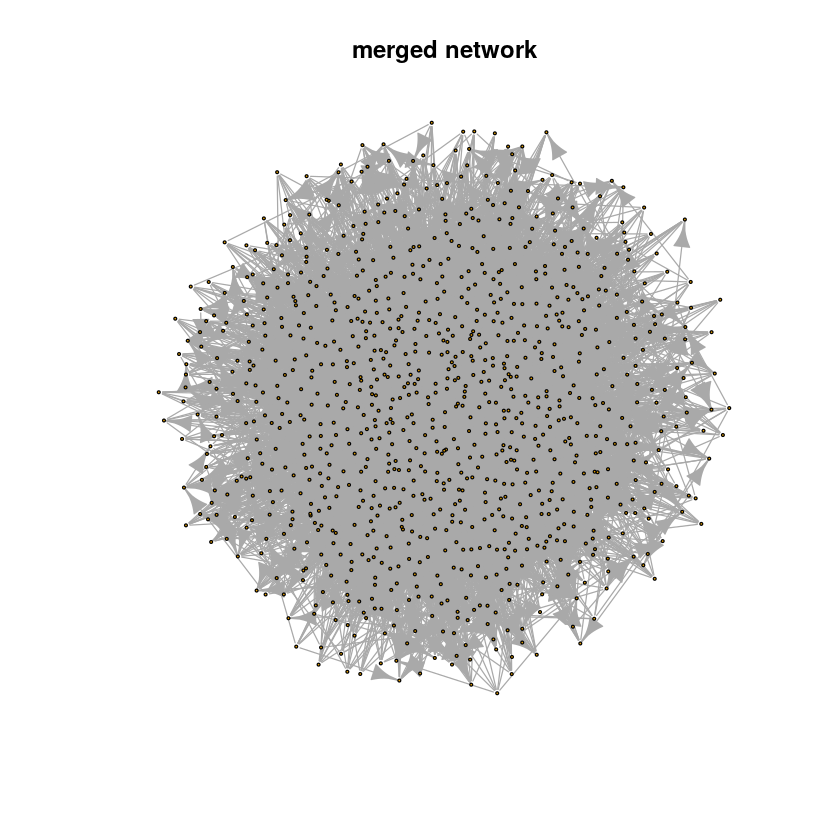

In [4]:
# merge two networks
edges = as_edgelist(g2_shuffled)
gg = add_edges(g1, as.vector(t(edges)))
plot(gg, vertex.size=1, vertex.label=NA, main='merged network')

# number of edges related to the first node
E(gg)[from(1)]

In [5]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

In [6]:
random_walk = function (g, num_steps, start_node, num_visited,
                        transition_matrix=NULL, teleportation=0,
                        method='uniform', median=NULL){
    
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node

    for(i in 1:num_steps){
#         fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        if(runif(1) < teleportation){
            if(method == 'uniform'){
                v = sample(1:vcount(g), 1)
            }
            if(method == 'personalized'){
                v = sample(1:vcount(g), 1, prob=num_visited)
            }
            if(method == 'median'){
                v = sample(median, 1)
            }
        }
        else{
            PMF = transition_matrix[v, ]
            v = sample(1:vcount(g), 1, prob=PMF)
        }
        num_visited[v] = num_visited[v] + 1  
    }
    
    return(num_visited)
}

In [7]:
evaluation = function(g, num_iter, num_steps, transition_matrix=NULL, 
                      teleportation=0, method='uniform'){
    
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
    
    num_visited = numeric(vcount(g))
    
    # initialize probability
    if(method == 'personalized'){
        num_visited = page_rank(g)$vector
    }
    if(method == 'median'){
        pr = page_rank(g)$vector
        idx = order(pr)
        median = c(idx[vcount(g)%/%2], idx[vcount(g)%/%2+1])
    }
    
    for (i in 1:num_iter){
        start_node = sample(1:1000, 1, replace=TRUE)
        num_visited = random_walk(g, num_steps, start_node, num_visited,
                                  transition_matrix, teleportation, 
                                  method, median)
#         if(method == 'median'){
#             idx = order(num_visited)
#             median = c(idx[vcount(g)%/%2], idx[vcount(g)%/%2+1])
#         }
    }

    prob_visited = num_visited/rep(num_steps*num_iter, vcount(g))
    deg = degree(g, mode='in')
    plot(prob_visited, type='l', main='visit probability distribution')
    plot(deg, prob_visited, main='probability v.s. degree')
}

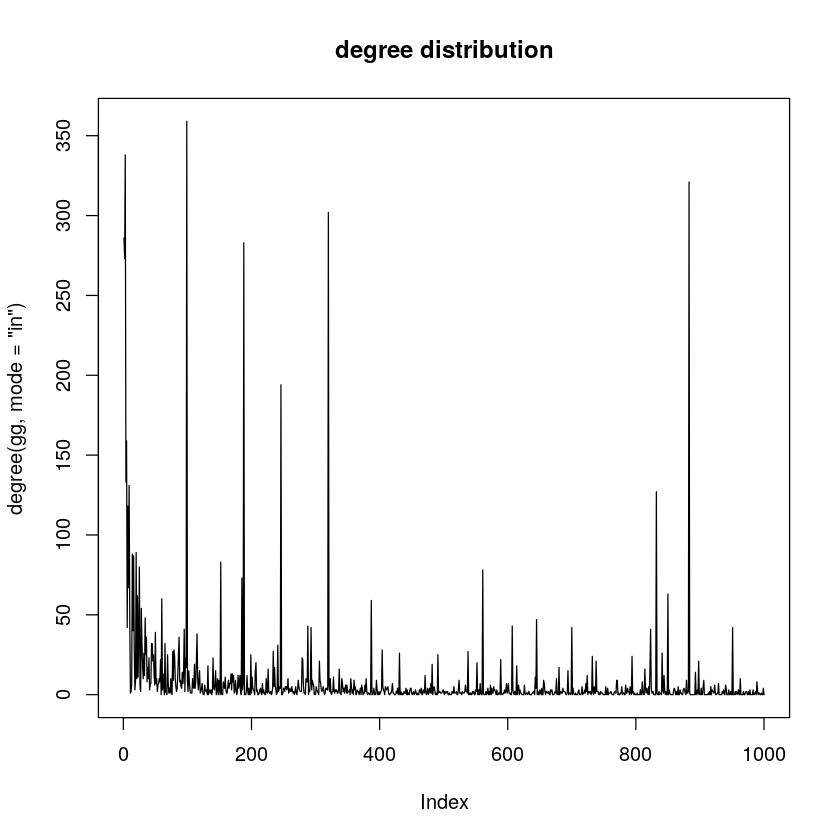

In [8]:
tm = create_transition_matrix(gg)
plot(degree(gg, mode='in'), type='l', main='degree distribution')

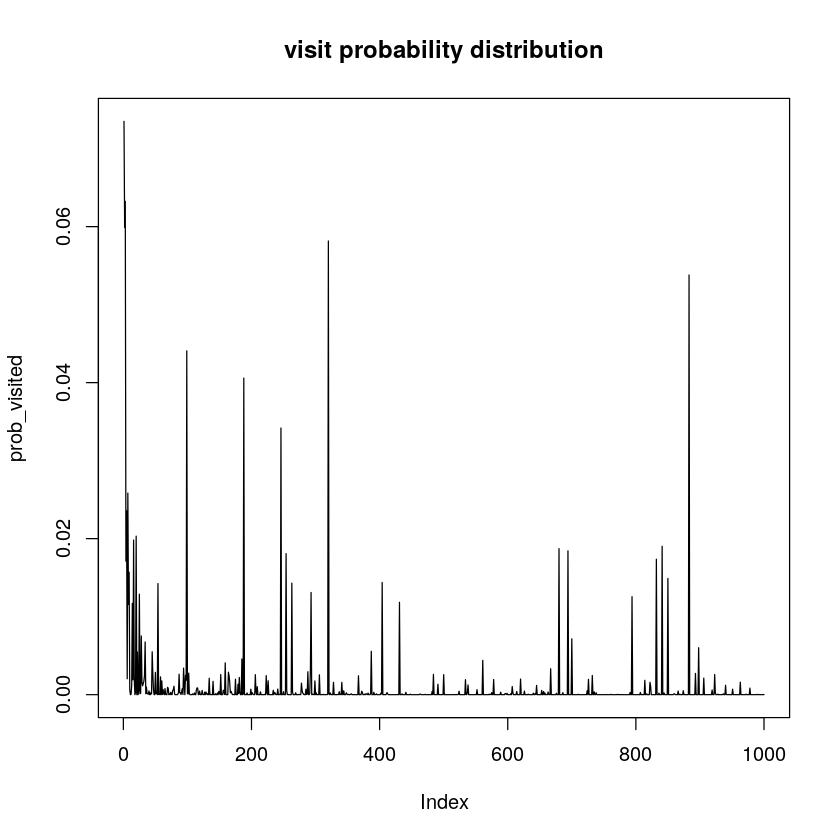

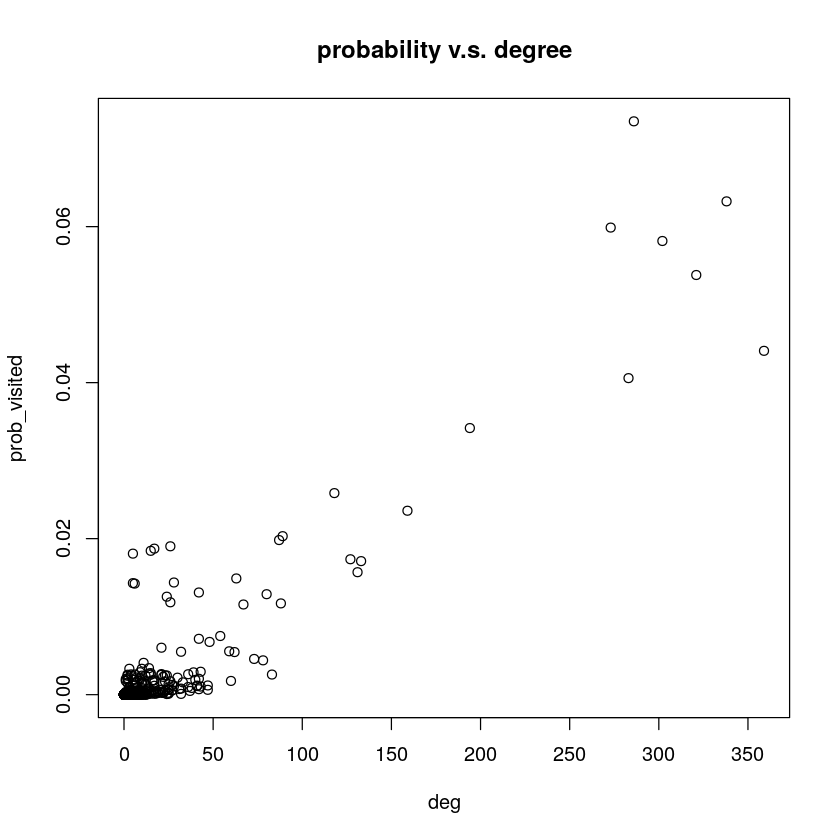

In [9]:
# 3(a) perform random walk on merged network
evaluation(gg, 100, 500, tm, 0)

## 3(b)

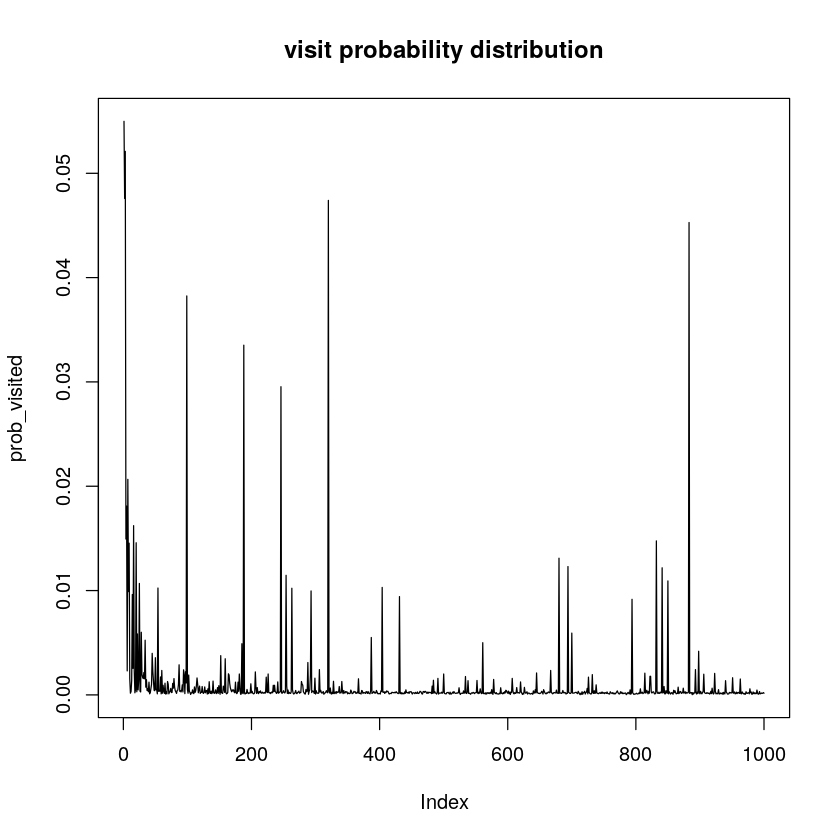

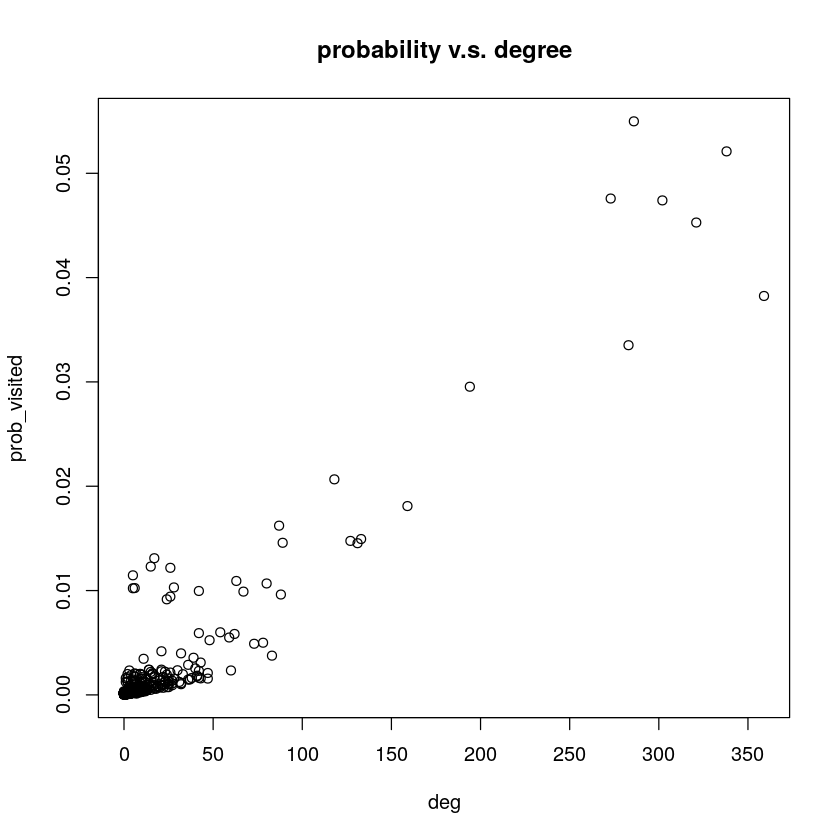

In [10]:
# 3(b) perform random walk on merged network with teleportation
evaluation(gg, 100, 500, tm, 0.15)

## 4(a)

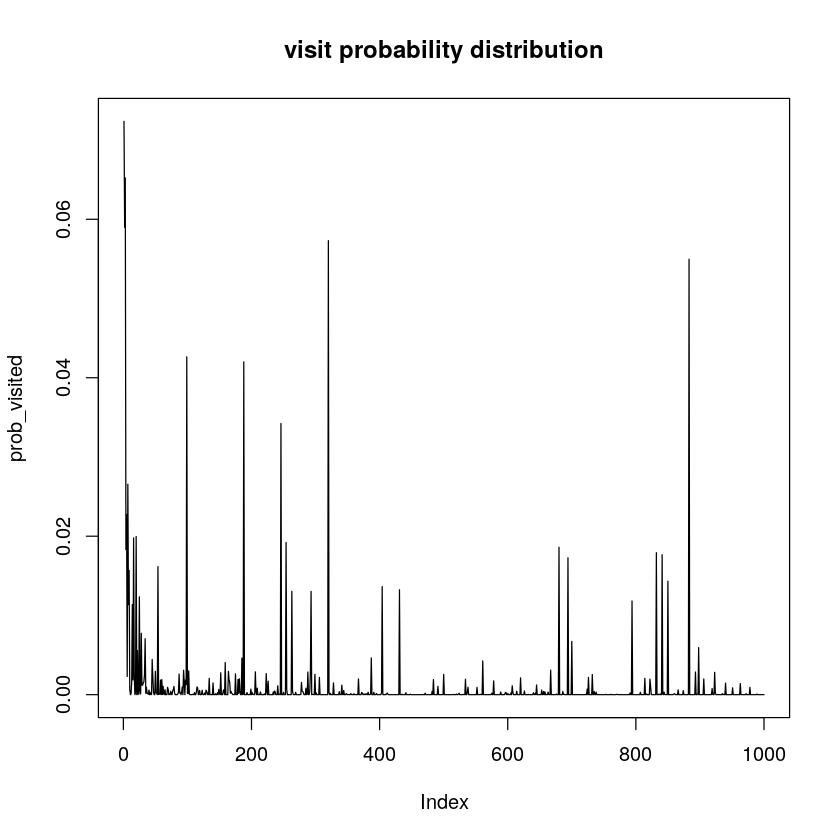

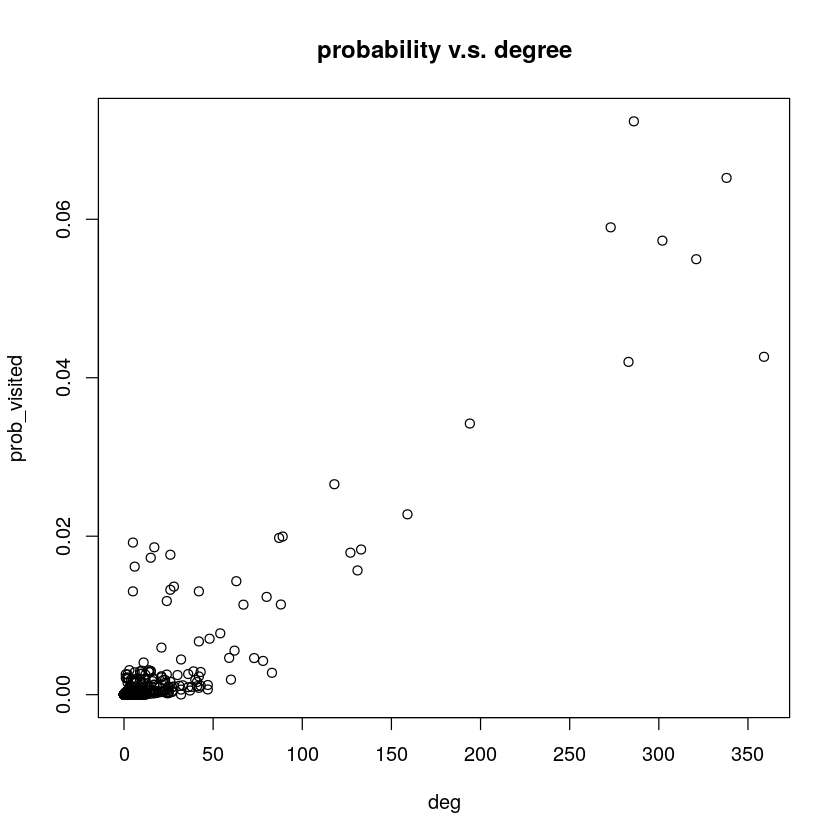

In [11]:
# 4(a) perform random walk on merged network with teleportation and pagerank prob
evaluation(gg, 100, 500, tm, 0.15, 'personalized')

## 4(b)

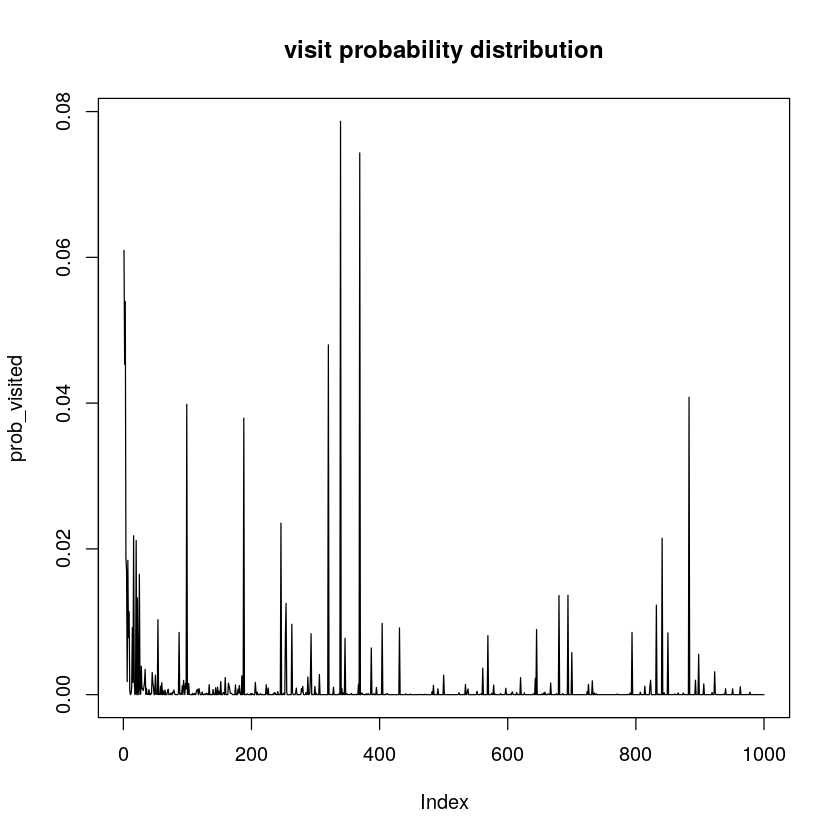

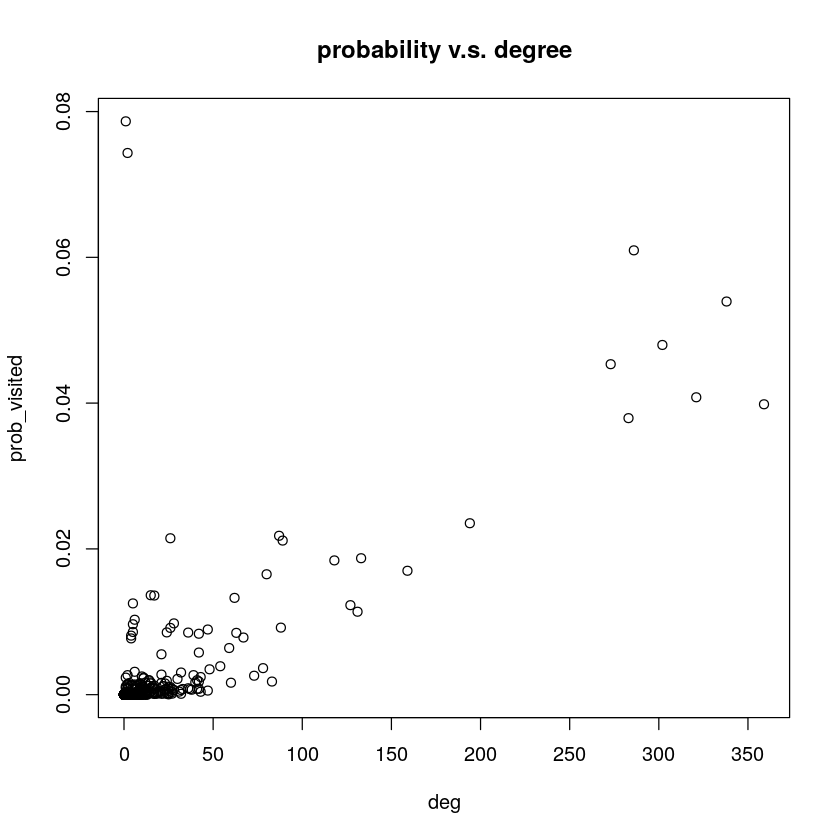

In [12]:
# 4(b) perform random walk on merged network 
# with teleportation to nodes with median pagerank
evaluation(gg, 100, 500, tm, 0.15, 'median')